# Basic drift characterization on time-stamped data
This tutorial shows how to implement a basic form of drift characterization on time-stamped data from almost any quantum-circuit based experiment on one or more qubits, including suitably time-ordered GST or RB experiments. The methods in this notebook can be used on data from any experiment that satisfies the following criteria: 

- The experiments consist of $S \geq 1$ different circuits, or sequences, acting on $Q \geq 1$ "qubits" (the quotes are because it is not essential that they are 2-level quantum systems, but they will be referred to as qubits throughout this tutorial).


- Sequence $s$ is repeated $N$ times during each of $T$ different time-intervals. Let $\tau_{s,1},\tau_{s,2},\dots,\tau_{s,T}$ denote times associated with these time-intervals (e.g., the start time or mid-point of each interval).


- The time-gap between consecutive sets of $N$ repeats of a sequence is approximately constant, and approximately independent of sequence. That is $t_{s,gap} \approx \tau_{s,t+1} - \tau_{s,t}$ for all $s,t$ and some constant $t_{s,gap}$ (the time gap is constant for each sequence), and $t_{gap} \equiv t_{s,gap} \approx t_{s',gap}$ for all $s,s'$ (the time gap is the same for every sequence).


- The result of each circuit has two possible outcomes for each qubit. Equivalently, the result of one repeat of a circuit can be represented as a bit string of length $Q$, where the $q^{\rm th}$ bit represents the outcome for qubit $q$.

Many characterization routines, include GST or RB, satisfy the above criteria *if* a suitable time-ordering for the repeats of all of the sequences is chosen. For example, 1 or 2 qubit GST consists of implement $S$ different sequences, and each sequence is repeated -- in total -- $R$ times. This set of experiments could be implemented by ....

The methods used in this notebook are designed to be fast, easy to use, and applicable to almost any time-stamped data. However, there are ....

#### How do the methods in this notebook work?

The drift detection works via spectral analysis, by implement a type of discrete Fourier transform on the data and looking for peaks that are larger than would be expected if there was no drift. This is detailed below in section 2.

#### What are acceptable and optimal values for $N$, $T$, $S$?

The total number of experiments is $N * T * S$, and for a fixed number of total experiments ... For fixed $N * T$, $N=1$ is alway the best option in principle (but note that the basic .....). However, if $T$ cannot be scaled as $1/N$ (e.g., because it is quicker to repeat the same sequence), it is not clear how best .... .

#### What don't the methods in this notebook do?

- This notebook does *not* provide specifications for what experiments to run to detect and characterize drift. One option is the GST sequences, but this is not the only option, and it will not always be the best option. Suggested experiments will be included in a future tutorial or examples notebook.


- They can detect and partially characterize drift, but they cannot certify that a device does not have drift. ....

In [78]:
# No special imports are required, beyond pygsti
from __future__ import print_function
import pygsti

# Imported for plotting output from the examples, and generate data.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

## 1. Input data format

The techniques do not require any particular type of gate sequences, nor do they need to know what the gate sequences are. In particular, they do not require GST data. As such, the format for the main input data is not a pyGSTi dataset, and is instead an ordinary numpy array (later, functionality to accept a form of pyGSTi dataset as input will be addded).

The input data format is a numpy array $M$ of dimension $(S \times Q \times T)$, where
$M[s,q,t]$ is the number of counts for qubit $q$, with sequence $s$, for the $t^{\rm th}$ implementation of that sequence. 

In the special case of $Q = 1$, the array can be either of dimension $(S \times 1 \times T)$ or $(S \times T)$, to avoid requiring the data to be padded with an unnecessary dimension.

For the purposes of this demonstration, we will take $S$, $Q$, $T$ and $N$ to be:

In [79]:
S = 3 #The number of different sequences
Q = 2 #The number of qubits
T = 100 #The number of timestamps
N = 5 #The number of repeats per timestamps

#### Aside: generating some fake data
We need some fake data to demonstrate the methods. 

One natural method for generating this data is to pick some time-dependent function for the underlying drifting probabilities associated with each sequence and each qubit -- which are what we are trying to characterize -- and then sample from these probabilities to generate some data. This is what we'll do below.
 
Below, we set the target probability of all the circuits, and plot them. There exact forms are not particularly relevant to this tutorial, and have been chosen fairly arbitrarily.

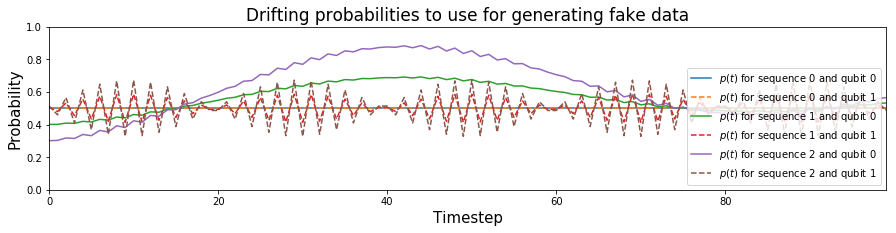

In [80]:
# The drifting probability, for each sequence and each qubit, at each timestep
prob = np.zeros((S,Q,T),float)


plt.figure(figsize=(15,3))

# We create some drifting probabilities, with sinosodial osscilating around a mean of 0.5,
# with the drift strength and frequencies varying between sequence (increasing with sequence
# index) and between qubit.
for s in range(0,S):
    for q in range(0,Q):
        for t in range(0,T):
            prob[s,q,t] = s*(q+0.08)*0.08*np.cos((t+1/2.)*(T-5)*np.pi/T) 
            prob[s,q,t] += s*(((q+1) %2))*(0.05*np.sin(t*0.8*np.pi/(T))+0.05*np.sin(t*0.9*np.pi/(T))-0.1*np.cos(t*2*1.24*np.pi/(T)))  
            prob[s,q,t] += 0.5
        string = '$p(t)$ for sequence '+str(s)+' and qubit '+str(q)
        if q == 0:
            plt.plot(prob[s,q,:],'-',label=string)
        if q == 1:
            plt.plot(prob[s,q,:],'--',label=string)

plt.legend(loc='lower right')
plt.xlim(0,T-1)
plt.ylim(0,1)
plt.title("Drifting probabilities to use for generating fake data",fontsize=17)
plt.xlabel("Timestep",fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.show()

From these drifting probabilities, we can now sample some data, to simulate an experiment in which the underlying probabilities drifted as specified above. Below, this data is plotted for one of the sequence-qubit pairs with significant drift.

It is probably not obvious, from simply looking at this data, whether it is likely consistent with standard fluctations due to measurement outcome randomness, or whether there are clear signs that the underlying probability is drifting. This is what the analysis attempts to deduce.

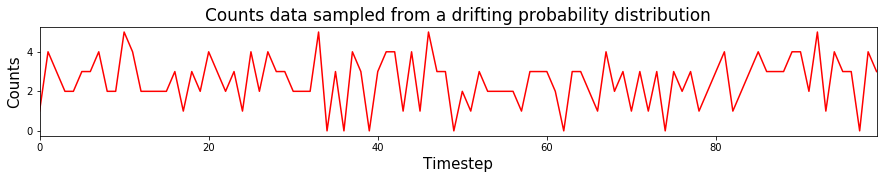

In [85]:
# generate some data from the specified drifting probabilities
data = np.zeros((S,Q,T),float)
for s in range(0,S):
    for q in range(0,Q):
        for t in range(0,T):
            data[s,q,t] = rnd.binomial(N,prob[s,q,t])

# plot the data for the specified qubit and sequence.
qubit = 1
sequence = 2
plt.figure(figsize=(15,2))
plt.plot(data[sequence,qubit,:],'r-',label=string)

plt.title("Counts data sampled from a drifting probability distribution",fontsize=17)
plt.xlabel("Timestep",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.xlim(0,T-1)
plt.show()

## 2. What are the analysis methods?

Some explanation of the method

In [95]:
qubit = 1
sequence = 2
confidence = 0.99

In [96]:
from pygsti.tools.drifttools import DCT
from scipy.stats import chi2

pt_power_spectrum = DCT(N*prob[sequence,qubit,:],counts=N)**2
data_power_spectrum = DCT(data[sequence,qubit,:],counts=N)**2

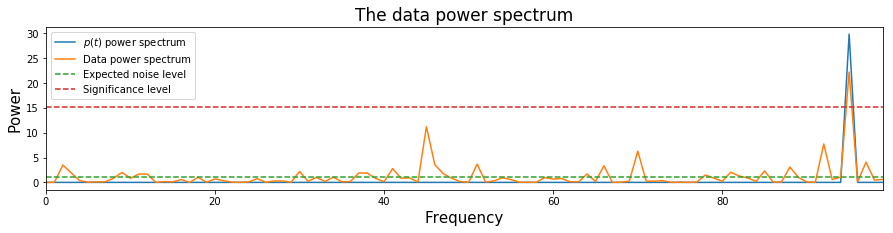

In [97]:
plt.figure(figsize=(15,3))
plt.plot(pt_power_spectrum,'-',label='$p(t)$ power spectrum')
plt.plot(data_power_spectrum,'-',label='Data power spectrum')
plt.plot(np.ones(T),'--',label='Expected noise level')
plt.plot(chi2.isf(1-confidence**(1/T),1)*np.ones(T),'--',label='Significance level')

plt.legend()
plt.xlim(0,T-1)
plt.title("The data power spectrum",fontsize=17)
plt.xlabel("Frequency",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.show()

## 3. Analysing time-stamped data
To analysis the data, we use the `pygsti.do_basic_drift_characterization()` function. This function takes two non-optional arguments:
- The data, as an ordinary numpy array of dimension $(S \times Q \times T)$ (or optionally as an $(S \times T)$ for the case of $Q=1$), consisting of measurement outcome counts. This has already been detailed above.


- The number of counts per timestep, $N$. This has to be specified, because it is not possible to reliably extract this from the data array (even though it will often correspond to the maximum value in the data array).

It also takes some optional arguments. There are two important arguments of this sort:

- `timestep`. This is the size of the gap between each set of $N$ repeats of each sequence. It should be specified in seconds. If it is specified, then the drift frequencies returned by this function are in Hertz. If it is not specified then the drift frequencies are integers between 0 and $T-1$, corresponding to the index of the DCT frequency (i.e., $1$ is the fundamental frequency, etc).


- `confidence`. This is the confidence of the hypothesis tests used to detect drift, and reconstruct estimates of the $p(t)$. More details of what this corresponds to are given later. The default value is 0.95.

In [6]:
timestep = 1e-6
confidence = 0.95

In [7]:
results = pygsti.do_basic_drift_characterization(data, N, timestep=timestep, confidence=confidence)

[[  1.59951409e-29   8.11851382e-01   2.10004485e+01   4.91165211e+00
    3.64782780e-01   2.84529146e+00   1.06154631e+00   1.09185203e+00
    3.91268762e-01   7.47354537e-01   9.86409839e-01   4.13202654e-01
    7.86286325e-01   4.77807720e-01   7.15105441e-01   5.72699534e-01
    1.35747778e-01   1.48750196e+00   1.60963610e-01   5.82929069e-01
    3.77910248e-02   1.18347771e-02   7.02943377e-01   7.06652487e-01
    2.81764635e-01   2.54646867e-01   1.19554977e+00   6.34206257e-01
    1.58958242e+00   2.75813140e-01   1.57450240e+00   7.22849945e-01
    9.62731756e-01   3.18385984e-01   5.02752666e-01   3.73059749e-01
    2.96302456e+00   4.08947744e-01   1.16087060e+00   5.44743958e-01
    4.27814036e-01   1.07071460e+00   1.89999079e+00   5.96035243e-01
    1.64482619e+00   6.87752975e-02   7.59155868e-01   1.02150167e+00
    5.28290499e-01   1.79874127e-01   2.96469862e-01   2.06401055e+00
    3.76522838e-02   1.43903713e+00   3.00839005e-01   2.75812006e+00
    5.90175670e-01  

We have now successfully run the analysis! 

## 4. Exploring the output

Let's look at the output. The function returns a `BasicDriftResults` object, which is essential just a container for a range of output created by the analysis. 
1. All properties starting with `.individual` are related to individual drift detection/characterization analysises of the data from each sequence and qubit. 
2. All properties starting with `.global` are ....
3. All other properties of ...are ...

### 4.1 Was drift detected?
The property of results is the `.all_detected` truth value. This ....

In [8]:
results.all_detected

True

### 4.2 What frequencies is the drift at?
The drift ....


In [20]:
print(results.frequencies)

[      0.    5000.   10000.   15000.   20000.   25000.   30000.   35000.
   40000.   45000.   50000.   55000.   60000.   65000.   70000.   75000.
   80000.   85000.   90000.   95000.  100000.  105000.  110000.  115000.
  120000.  125000.  130000.  135000.  140000.  145000.  150000.  155000.
  160000.  165000.  170000.  175000.  180000.  185000.  190000.  195000.
  200000.  205000.  210000.  215000.  220000.  225000.  230000.  235000.
  240000.  245000.  250000.  255000.  260000.  265000.  270000.  275000.
  280000.  285000.  290000.  295000.  300000.  305000.  310000.  315000.
  320000.  325000.  330000.  335000.  340000.  345000.  350000.  355000.
  360000.  365000.  370000.  375000.  380000.  385000.  390000.  395000.
  400000.  405000.  410000.  415000.  420000.  425000.  430000.  435000.
  440000.  445000.  450000.  455000.  460000.  465000.  470000.  475000.
  480000.  485000.  490000.  495000.]


In [9]:
print(results.global_drift_frequencies)

[  10000.  475000.]


### 4.3 The averaged power spectrums

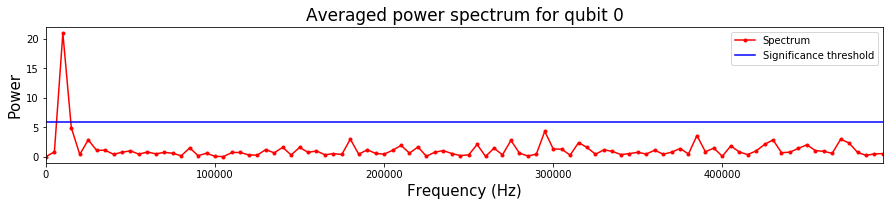

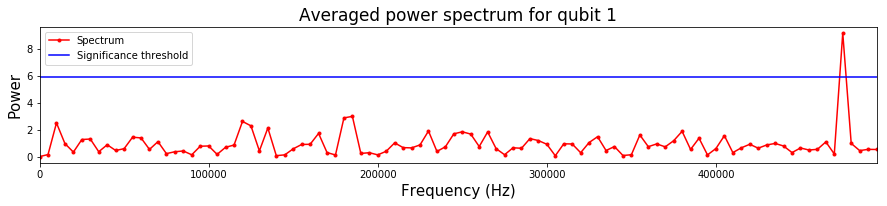

In [36]:
max_power = 0
for q in range(0,Q):
    max_power = max(max_power,np.max(results.global_power_spectrum[q]))

for q in range(0,Q):
    plt.figure(figsize=(15,2.5))
    plt.plot(results.frequencies,results.global_power_spectrum[q],'r.-',label='Spectrum')
    plt.plot(results.frequencies,results.global_significance_threshold*np.ones(T),'b-',label='Significance threshold')
    plt.title("Averaged power spectrum for qubit {}".format(q),fontsize=17)
    plt.xlabel("Frequency (Hz)",fontsize=15)
    plt.ylabel("Power",fontsize=15)
    #plt.ylim(0,max_power)
    plt.xlim(0,max(results.frequencies))
    plt.legend()
    plt.show()

### 4.4 Analysis for individual sequences

In [27]:
qubit = 1
sequence = 2

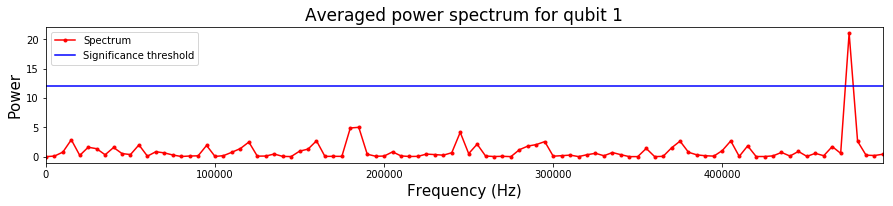

In [35]:
plt.figure(figsize=(15,2.5))
plt.plot(results.frequencies,results.individual_power_spectrum[sequence,qubit,:],'r.-',label='Spectrum')
plt.plot(results.frequencies,results.individual_max_power_threshold*np.ones(T),'b-',label='Significance threshold')
plt.title("Averaged power spectrum for qubit {}".format(q),fontsize=17)
plt.xlabel("Frequency (Hz)",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.xlim(0,max(results.frequencies))
plt.legend()
plt.show()

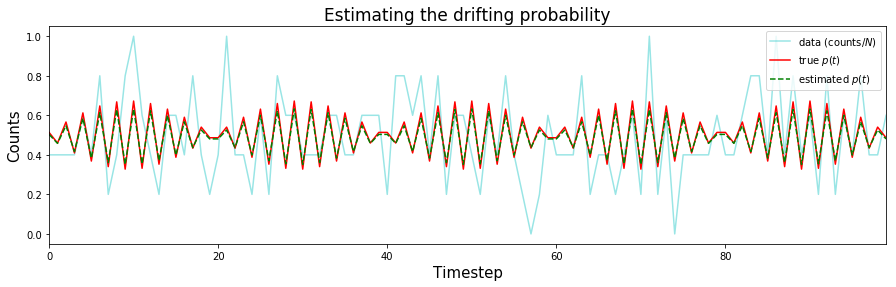

In [51]:
plt.figure(figsize=(15,4))
plt.plot(data[sequence,qubit,:]/N,'c-',alpha=0.4,label='data (counts/$N$)')
plt.plot(prob[sequence,qubit,:],'r-',label='true $p(t)$')
plt.plot(results.individual_reconstruction[sequence,qubit,:],'g--',label='estimated $p(t)$')

plt.title("Estimating the drifting probability",fontsize=17)
plt.xlabel("Timestep",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.xlim(0,T-1)
plt.legend(loc = 'upper right')
plt.show()

## 5. Interpretting the output
Things to mention:

- Multiple statistical testing issues.